# Rock Paper Scissors


## Setup

simple setup like seeding and setting directories for saving the output

In [1]:
import os
from notebook_utils import *
MODEL_SAVE_DIR = os.path.join('.','model_states')
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

assert os.path.exists(MODEL_SAVE_DIR)
print('MODEL_SAVE_DIR = %s' % MODEL_SAVE_DIR)

MODEL_SAVE_DIR = ./model_states


In [2]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np


# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)


# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version: %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "is NOT"))

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.enabled = False

Using Pytorch version: 1.13.1. GPU is NOT available


## ModelGeneration and Training

### Setup

Before we start with the training we want to define some global setup variables:

In [3]:
CLASSES = ['rock', 'paper', 'scissors']
model_input_size= (64,64)

### Loading the already preprocessed Data

In [4]:
file_pattern_training_data = '/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/*/*.png'
file_pattern_validation_data = '/Users/amling/uni/shifumi/DataEng/datasets/xAI-Proj-M-validation_set_pp_01_grey/*/*.png'
file_pattern_test_data = '/Users/amling/uni/shifumi/DataEng/datasets/xAI-Proj-M-validation_set_pp_01_grey/*/*.png'

train_images, train_labels ,train_data_paths = get_images_and_labels_from_filepattern(file_pattern_training_data, model_input_size)
val_images, val_labels, val_data_paths = get_images_and_labels_from_filepattern(file_pattern_validation_data, model_input_size)
test_images, test_labels, test_data_paths = get_images_and_labels_from_filepattern(file_pattern_test_data, model_input_size)


print(f" training images.shape: {train_images.shape} - labels.shape: {train_labels.shape}")
print(f"training data from {train_data_paths[:2]}\n")
print(f" val images.shape: {val_images.shape} - labels.shape: {val_labels.shape}")
print(f"val data from {val_data_paths[:2]}\n")
print(f" test images.shape: {test_images.shape} - labels.shape: {test_labels.shape}")
print(f"test data from {test_data_paths[:2]}\n")

 training images.shape: (7578, 64, 64, 1) - labels.shape: (7578,)
training data from ['/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/scissors/2__3n4i3lKB3nZOpDVv.png', '/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/scissors/3__scissors02-019.png']

 val images.shape: (59, 64, 64, 1) - labels.shape: (59,)
val data from ['/Users/amling/uni/shifumi/DataEng/datasets/xAI-Proj-M-validation_set_pp_01_grey/rock/rock_44.png', '/Users/amling/uni/shifumi/DataEng/datasets/xAI-Proj-M-validation_set_pp_01_grey/scissors/scissors_32.png']

 test images.shape: (59, 64, 64, 1) - labels.shape: (59,)
test data from ['/Users/amling/uni/shifumi/DataEng/datasets/xAI-Proj-M-validation_set_pp_01_grey/paper/paper_8.png', '/Users/amling/uni/shifumi/DataEng/datasets/xAI-Proj-M-validation_set_pp_01_grey/scissors/scissors_32.png']



### Building the model

The following section builds the Model

In [5]:
# definition of parameters
batch_size= 32
training_epoches=100
use_batch_normalization=False
use_dropouts = True
dropout_probability = 0.5
learning_rate = 1e-4

#### The VGG 16 inspired model

Our model uses 4 blocks of convolutional layers and afterwards 3 fully connected layers with dropout layers.

TODO write about the parameters

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class RPS_CNN(nn.Module):
    def __init__(self, activate_dropout : bool =True, dropout_probability: float =0.5, batch_normalization : bool =False, convolution_kernel_size : int = 3):
        super(RPS_CNN, self).__init__()
        # TODO redo the model based on vgg 16, keep convolutions as is, but change according to vgg 16, less+
        # TODO add parameter to use or not to use batch normalization
        # TODO use relu on every layer
        # TODO also check the training method if it is implemented correctly
        self.activate_dropout = activate_dropout
        self.dropout_probability = dropout_probability
        self.batch_normalization = batch_normalization

        # first block of convolutional layers
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=convolution_kernel_size, padding=1)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=convolution_kernel_size, padding=1)
        # add a convolutional layer 32x32
        self.bn1 = nn.BatchNorm2d(32)


        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=convolution_kernel_size, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=convolution_kernel_size, padding=1)
        # add Convolution Layer 64x64
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=convolution_kernel_size, padding=1)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=convolution_kernel_size, padding=1)
        self.conv3_3 = nn.Conv2d(128, 128, kernel_size=convolution_kernel_size, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=convolution_kernel_size, padding=1)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=convolution_kernel_size, padding=1)
        self.conv4_3 = nn.Conv2d(256, 256, kernel_size=convolution_kernel_size, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.maxpool = nn.MaxPool2d(2,2)
        self.adaptive_maxpool = nn.AdaptiveMaxPool2d(2)

        #self.fc1 = nn.Linear(64*2*2, 500)
        self.fc1 = nn.Linear(1024, 500)
        self.dropout1 = nn.Dropout(self.dropout_probability)
        self.fc2 = nn.Linear(500, 500)
        self.dropout2 = nn.Dropout(self.dropout_probability)
        self.fc3 = nn.Linear(500, 3)

    def forward(self, x):
        # feature extraction part
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        if self.batch_normalization:
            x= self.bn1(x)
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        if self.batch_normalization:
            x= self.bn2(x)
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        if self.batch_normalization:
            x= self.bn3(x)
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        if self.batch_normalization:
            x= self.bn4(x)
        x = self.adaptive_maxpool(x)
        # actual classification part
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        if self.activate_dropout:
            x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        if self.activate_dropout:
            x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [7]:
# define a dataset for Pytorch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RPSDataset(Dataset):
    """
    our custom Rock Paper Scissors Dataset
    """
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = torch.LongTensor(y)
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        if self.transforms is not None:
            x = self.transforms(x)
        return x, y

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(0, shear=0.2),         # random shear 0.2
    transforms.RandomAffine(0, scale=(0.8, 1.2)),  # random zoom 0.2
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])
    
image_transforms = transforms.Compose([
    transforms.ToTensor()   
])

In [8]:
train_dataset = RPSDataset(train_images, train_labels, train_transforms)
val_dataset = RPSDataset(val_images, val_labels, image_transforms)
test_dataset = RPSDataset(test_images, test_labels, image_transforms)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validationloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

images.shape: (32, 1, 64, 64) - labels.shape: (32,)


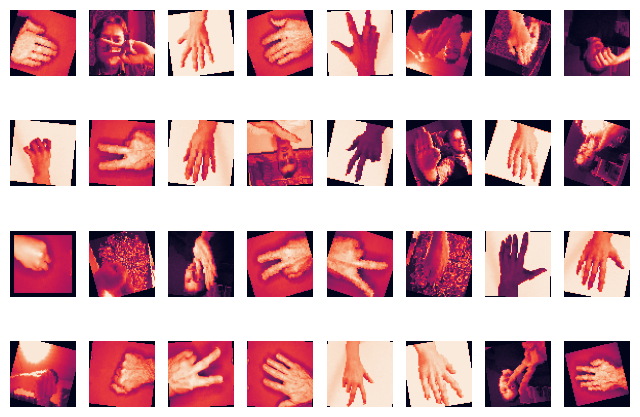

In [9]:
# look a train dataset
show_images_from_dataloader(trainloader)

images.shape: (32, 1, 64, 64) - labels.shape: (32,)


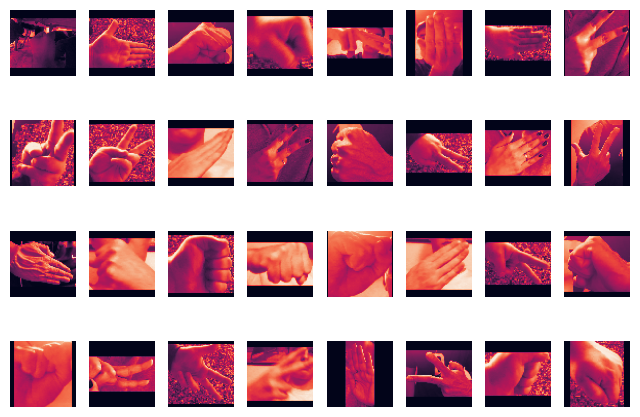

In [10]:
# look a validation dataset
show_images_from_dataloader(validationloader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model, loss function, and optimizer
model = RPS_CNN(activate_dropout=use_dropouts, dropout_probability=dropout_probability, batch_normalization=use_batch_normalization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def test_accuracy(testloader):
    # Test the model on the test dataset
    outcome = {}
    with torch.no_grad():
        correct = 0
        total = 0
        class_correct = [0. for i in range(len(CLASSES))]
        class_total = [0. for i in range(len(CLASSES))]
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(len(c)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
        print(f'Accuracy of the network on the test set: {100 * correct / total}%')
        outcome['total'] = 100 * correct / total
        for i in range(len(CLASSES)):
            if class_total[1]>0:
                print(f'Accuracy of {CLASSES[i]} : {100 * class_correct[i] / class_total[i]}%')
                outcome[CLASSES[i]] = 100 * class_correct[i] / class_total[i]
            else:
                print(f'Accuracy of {CLASSES[i]} : could not be measured, no test images%')
    return outcome

def train(epoches, training_data, val_data, save_model_each_x_epoches=10):
    hist=[]
    for epoch in range(epoches):
        running_loss = 0.0
        for i, data in enumerate(training_data, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(trainloader)
        print(f'Epoch {epoch + 1} loss: {epoch_loss}')
        hist.append({'loss': epoch_loss, 'accuracy_measures': test_accuracy(val_data)})
        if save_model_each_x_epoches >0:
            if (epoch+1)%save_model_each_x_epoches == 0:
                MODEL_SAVE_PATH = f'./model_states/pytk_rock_paper_scissors_{epoch +1}epoches__Dropouts_{str(model.activate_dropout)}__BatchNorm_{str(model.batch_normalization)}.pt'
                torch.save(model.state_dict(),MODEL_SAVE_PATH)
    return hist

import time
start_time = time.time()
hist = train(epoches=training_epoches, training_data= trainloader, val_data= validationloader)
training_time_s = time.time() - start_time

Epoch 1 loss: 1.0986960824531844
Accuracy of the network on the test set: 35.59322033898305%
Accuracy of rock : 68.42105263157895%
Accuracy of paper : 0.0%
Accuracy of scissors : 40.0%
Epoch 2 loss: 1.0984196582423986
Accuracy of the network on the test set: 32.20338983050848%
Accuracy of rock : 15.789473684210526%
Accuracy of paper : 30.0%
Accuracy of scissors : 50.0%
Epoch 3 loss: 1.0903281939180591
Accuracy of the network on the test set: 38.983050847457626%
Accuracy of rock : 26.31578947368421%
Accuracy of paper : 15.0%
Accuracy of scissors : 75.0%
Epoch 4 loss: 0.8941842569077568
Accuracy of the network on the test set: 54.23728813559322%
Accuracy of rock : 73.6842105263158%
Accuracy of paper : 40.0%
Accuracy of scissors : 50.0%
Epoch 5 loss: 0.6193155040217855
Accuracy of the network on the test set: 47.45762711864407%
Accuracy of rock : 73.6842105263158%
Accuracy of paper : 40.0%
Accuracy of scissors : 30.0%
Epoch 6 loss: 0.5168084907129344
Accuracy of the network on the test se

### Testing against the validation and testing dataset provided

In [ ]:
print('testing against the validation dataset')
test_accuracy(validationloader)

In [ ]:
print('testing against the testing dataset')
test_accuracy(testloader)

## Evaluation

now there comes the evaluation part

In [ ]:
print(f'training took {convert_seconds(training_time_s)}')
print(model)

In [ ]:
# plot the validation loss during training
show_validation_loss(hist, save_path=f'./model_states/{training_epoches}epoches_val_loss__Dropouts_{str(model.activate_dropout)}__BatchNorm_{str(model.batch_normalization)}.png')

In [ ]:
# plot the validation loss
show_training_accuracy(hist, save_path=f'./model_states/{training_epoches}epoches_accuracy__Dropouts_{str(model.activate_dropout)}__BatchNorm_{str(model.batch_normalization)}.png')

In [ ]:
# save history to a file and reload it
import pickle

with open(f"./model_states/training_history{training_epoches}epoches__Dropouts_{str(model.activate_dropout)}__BatchNorm_{str(model.batch_normalization)}", "wb") as fp:   #Pickling
    pickle.dump(hist, fp)
with open(f"./model_states/training_history{training_epoches}epoches__Dropouts_{str(model.activate_dropout)}__BatchNorm_{str(model.batch_normalization)}", "rb") as fp:   # Unpickling
    read=pickle.load(fp)
print(read)